In [1]:
import numpy as np
from scipy.stats.distributions import norm
import matplotlib.pylab as plt
import matplotlib.cbook
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import sys
sys.path.append('../../zdrojaky')
from tsplot import tsplot
import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning,matplotlib.cbook.mplDeprecation))
np.set_printoptions(precision=3)
import scipy.stats as ss
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic


<ipython-input-1-fded1773e3a6>:11: MatplotlibDeprecationWarning: mplDeprecation was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use matplotlib.MatplotlibDeprecationWarning instead.
  warnings.simplefilter(action='ignore', category=(FutureWarning,matplotlib.cbook.mplDeprecation))


## Time series analysis: Heart-rates

### Description

Each series contains 1800 evenly-spaced measurements of instantaneous heart rate from a single subject. The measurements (in units of beats per minute) occur at 0.5 second intervals, so that the length of each series is exactly 15 minutes.

Mean			STD
92.59611438888888 	 5.487813831166556


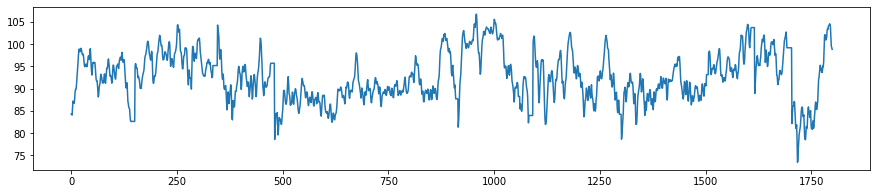

In [2]:
with open("./hr.11839.txt") as f:
    d = f.readlines()
d = [float(a.rstrip()) for a in d]
print("Mean\t\t\tSTD")
print(np.mean(d),"\t", np.std(d))
plt.figure(figsize=(15, 3))
plt.plot(d)
plt.show()
mean_constant = np.mean(d)

Looking at the time series I can't see any specific seasonality. The amplitude of the wave does not increase in time so I assume the appropriate model is *additive*.

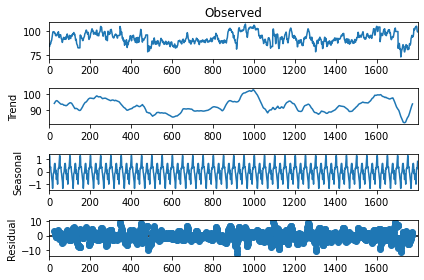

In [3]:
result = seasonal_decompose(d, period=50, model='additive')
result.plot()
plt.show()

The residuals show pattern. Further investigation is needed.

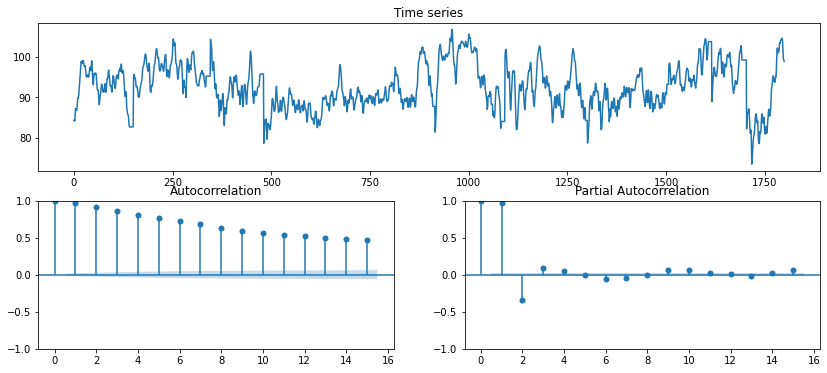

In [4]:
tsplot(d)

The quickguide shown in lecture 4 would point us to look at AR models.

Discussion:

  - Is the local variance consistent across time series?
      - It seems to be.
  
  - Is it stationary?
      
      - Mean moves around the 92.5 value but there seem to be systematic increase and decrease in values so the mean is not constant. *But* - taken from lecture 3, AR(2) process is always stationary (see https://www.xycoon.com/ar2_process.htm) and this looks like AR(2).
      

![Quickguide for selecting correct model](./quick1.png "Text to show on mouseover").

  - Does it have trend?
  
      - It looks like it, first order in PACF is close to 1. Let's check it by summing the data by 4, 8, 16, 32 and 64 datapoints.

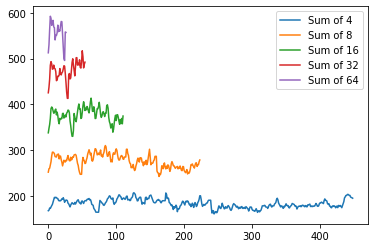

In [5]:
for p in range(2,7):
    split = 2**p
    limit = len(d)//split
    new_d = [np.sum(d[i*p:(i+1)*p]) for i in range(limit-1)]
    plt.plot(new_d, label="Sum of "+str(split))
    plt.legend()
plt.show()

Let's try to differentiate it and see if it is similar to white noise.

<Figure size 1080x360 with 0 Axes>

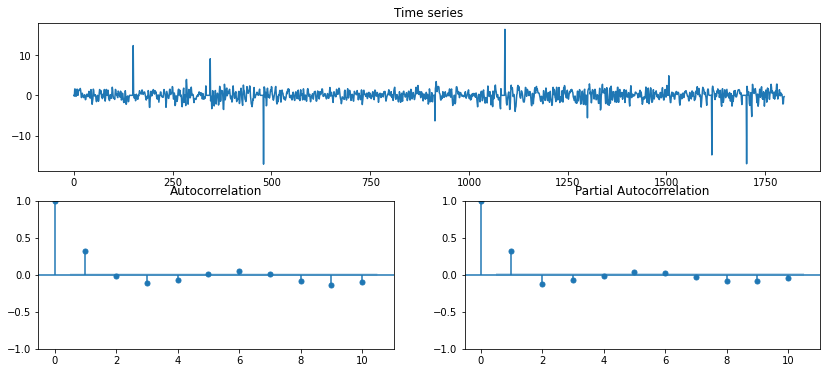

In [6]:
dd = np.array(d)
plt.figure(figsize=(15, 5))
tsplot(np.diff(dd), lags=10)
plt.show()

The trend was removed, and PACF, ACF look better. This does not look like AR process. The time series was created by measuring a person during *activities*. The peaks can show us the start or change of activity.

Let's diff once more just to see how it looks. 

<Figure size 1080x360 with 0 Axes>

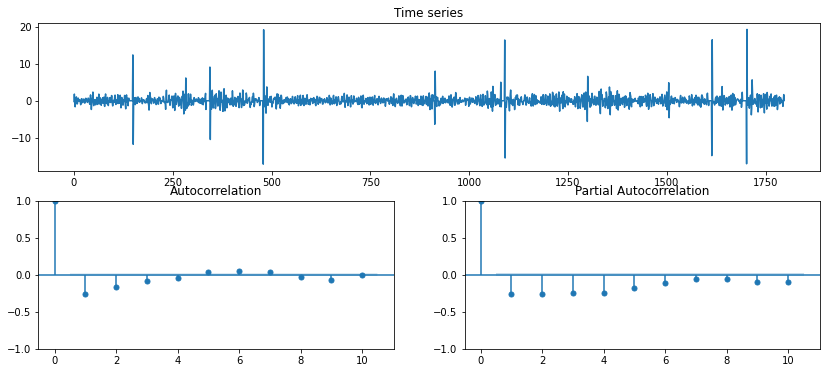

In [7]:
plt.figure(figsize=(15, 5))
tsplot(np.diff(dd,2), lags=10)

2nd differentiation did not bring more insight into the data, PACF has "weird" values and outliers in timeseries grew bigger. I will use 1 differentiation and I will try to remove outliers by removing points outside [25, 27] percentile. Inspiration from https://www.analyticsvidhya.com/blog/2021/05/feature-engineering-how-to-detect-and-remove-outliers-with-python-code/

percentile25=-0.6366500000000102
percentile75=0.7481999999999971
IQR 1.3848500000000072
Number of points: (1799, 1)
After outlier removal (1782, 1)


<AxesSubplot: >

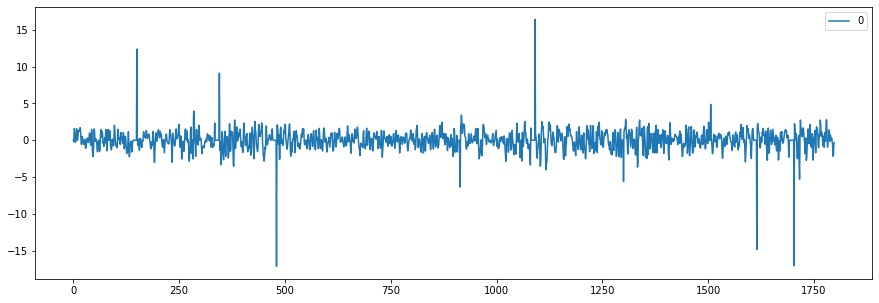

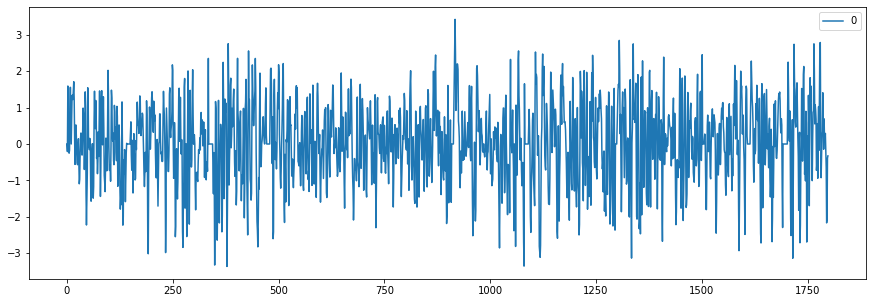

In [8]:
df = pd.DataFrame(np.diff(dd))
df.plot(figsize=(15,5))
percentile25 = float(df.quantile(0.25))
percentile75 = float(df.quantile(0.75))
print(f"{percentile25=}\n{percentile75=}")
iqr = percentile75 - percentile25
print("IQR", iqr)
upper_limit = percentile75 + 2 * iqr
lower_limit = percentile25 - 2 * iqr
print("Number of points:", df.shape)
df = df[df < upper_limit]
df = df[df > lower_limit]
df = df.dropna()
print("After outlier removal", df.shape)
df.plot(figsize=(15,5))

### AR model on differentiated data

AR model with $p$ order takes into account previous datapoints up to $p$ order with, each with a fitted parameter $\phi_i$. Parameter $c$ is constant offset.

$ X_t = c + \phi_1 X_{t-1} + \ldots + \phi_p X_{t-p} + \varepsilon_t\\ $

In [9]:
def logl_AIC_BIC(summary):
    # returns log likelihood(higher is better), aic(lower is better), bic(lower is better)
    data = summary.tables[0].data
    logl = data[1][3]
    aic = data[3][3]
    bic = data[4][3]
    return float(logl), float(aic), float(bic)

def modulus(summary):
    # every modulus should be outside normal circle
    data = summary.tables[2].data
    data = summary.tables[2].data[1:]
    return [float(modulus[3]) for modulus in data]

I used function `ar_select_order` to calculate metrics for different orders of AR model.

**LogLikelihood** - higher is better as it shows the likelihood of selected model producing observed samples.

**AIC and BIC** - lower is better, they describe how much information is "lost" in the residues not covered by selected model.

In [10]:
d = df.to_numpy()

In [11]:
out = ar_select_order(d, maxlag=5, ic='bic', trend='c')
print(f'Vhodné řády: {out.ar_lags}')
print("LogL, \tAIC, \tBIC")
for lag in out.ar_lags:
    res = AutoReg(d, lags = lag, trend='c').fit()
    print("Lag:", lag)
    print(logl_AIC_BIC(res.summary()))
    print("modulus:", modulus(res.summary()))
# choosing model with 5 lag
res = AutoReg(d, lags = 5, trend='c').fit()

Vhodné řády: [1, 2, 3, 4, 5]
LogL, 	AIC, 	BIC
Lag: 1
(-2320.282, 4646.565, 4663.02)
modulus: [1.7981]
Lag: 2
(-2158.328, 4324.656, 4346.593)
modulus: [1.5676, 1.5676]
Lag: 3
(-2130.536, 4271.072, 4298.491)
modulus: [1.6723, 1.6723, 2.1559]
Lag: 4
(-2126.143, 4264.286, 4297.186)
modulus: [1.9964, 1.9964, 1.9739, 1.9739]
Lag: 5
(-2105.964, 4225.928, 4264.307)
modulus: [1.44, 1.3488, 1.3488, 1.6135, 1.6135]


All criteria have best values for order $5$, modulus is outside normal circle.
This is high lag number.

Outliers in residuals are visible, histogram looks like normal distribution and correlogram shows some reside in higher lags.

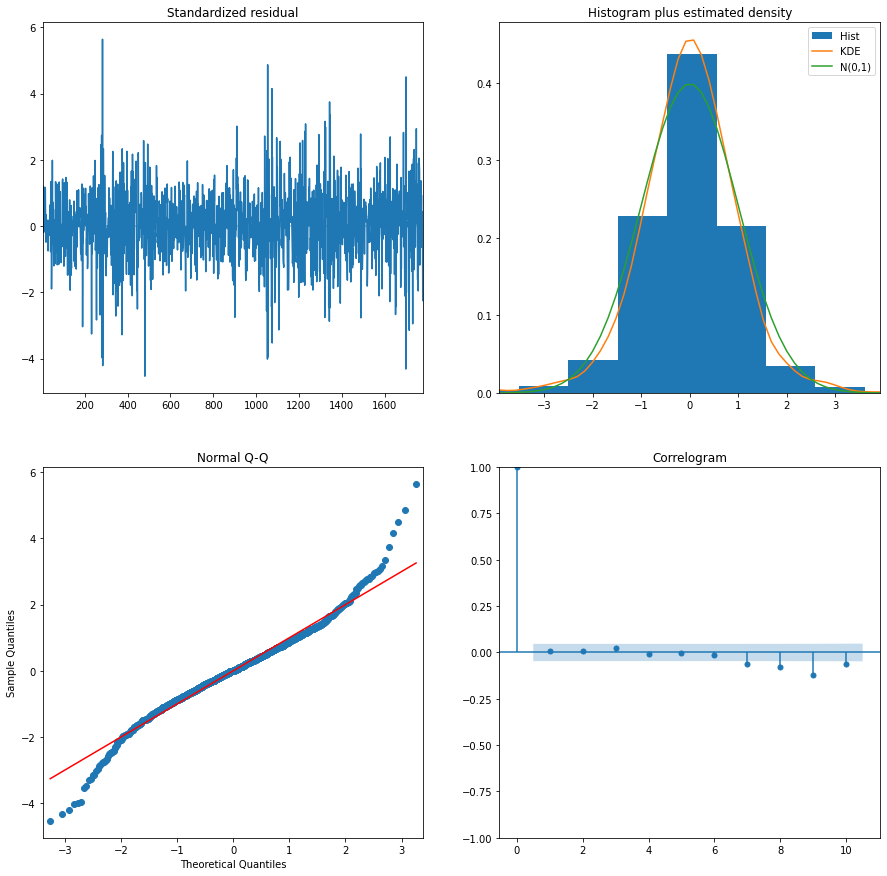

In [12]:
res.plot_diagnostics(figsize=(15,15))
plt.show()

## ARIMA

AR models do not seem to simulate the processes well. I try to see if mixing with Moving Average process helps. Also, I have differentiated it before and 2nd differentiation was rejected so I will prohibit it. 

In [13]:
import pmdarima as pm
stepwise_fit = pm.auto_arima(d, start_p=1, start_q=1,
                             max_p=5, max_q=5, m=0,
                             start_P=0, seasonal=False,
                             # D = 0
                             d=0, trace=True,
                             information_criterion='bic',
                             stepwise=False)                      

 ARIMA(0,0,0)(0,0,0)[0]             : BIC=5310.185, Time=0.21 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=4331.510, Time=0.27 sec
 ARIMA(0,0,2)(0,0,0)[0]             : BIC=4275.917, Time=0.63 sec
 ARIMA(0,0,3)(0,0,0)[0]             : BIC=4281.721, Time=0.47 sec
 ARIMA(0,0,4)(0,0,0)[0]             : BIC=4284.436, Time=1.21 sec
 ARIMA(0,0,5)(0,0,0)[0]             : BIC=4281.086, Time=0.86 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=4657.835, Time=0.18 sec
 ARIMA(1,0,1)(0,0,0)[0]             : BIC=4286.261, Time=0.23 sec
 ARIMA(1,0,2)(0,0,0)[0]             : BIC=4282.349, Time=0.93 sec
 ARIMA(1,0,3)(0,0,0)[0]             : BIC=4274.531, Time=1.88 sec
 ARIMA(1,0,4)(0,0,0)[0]             : BIC=4281.797, Time=1.51 sec
 ARIMA(2,0,0)(0,0,0)[0]             : BIC=4343.542, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0]             : BIC=4273.969, Time=0.14 sec
 ARIMA(2,0,2)(0,0,0)[0]             : BIC=4279.404, Time=0.51 sec
 ARIMA(2,0,3)(0,0,0)[0]             : BIC=4248.932, Time=1.93 sec
 ARIMA(3,0

1 differentiation, 2 lags for AR and 3 for MA give BIC of 4248.932 compared to AR(5) with BIC 4264.307. This is not much of a difference I think.

In [14]:
import pmdarima as pm
stepwise_fit = pm.auto_arima(d, start_p=1, start_q=1,
                             max_p=5, max_q=5, m=0,
                             start_P=0, seasonal=False,
                             # D = 0
                             d=0, trace=True,
                             information_criterion='aic',
                             stepwise=False)                      

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5304.700, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4320.539, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=4259.461, Time=0.24 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=4259.779, Time=0.44 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=4257.008, Time=0.62 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=4248.173, Time=0.62 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4646.864, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4269.805, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4260.407, Time=0.43 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=4247.104, Time=0.96 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=4248.884, Time=1.31 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4327.086, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4252.027, Time=0.14 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=4251.976, Time=0.52 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=4216.020, Time=1.77 sec
 ARIMA(3,0

Also AIC chose p=2 and q=3 with 4216.020 compared to AR(5) with 4225.928.
I will choose ARIMA(2, 0,3) for differentiad data.

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1782
Model:                 ARIMA(2, 0, 3)   Log Likelihood               -2102.010
Date:                Thu, 20 Oct 2022   AIC                           4216.020
Time:                        16:32:30   BIC                           4248.932
Sample:                             0   HQIC                          4228.175
                               - 1782                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8093      0.028     28.566      0.000       0.754       0.865
ar.L2         -0.8816      0.026    -34.315      0.000      -0.932      -0.831
ma.L1          0.0046      0.034      0.136      0.892      -0.063       0.072
ma.L2          0.3203      0.033      9.697      0.000       0.256       0.385
ma.L3          0.5531      0.028     20.051      0.000       0.499       0.607
sigma2         0.6192      0.016     38.124      0.000       0.587       0.651
===================================================================================
Ljung-Box (L1) (Q):                   4.65   Jarque-Bera (JB):               454.68
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                            -0.08
Prob(H) (two-sided):                  0.23   Kurtosis:                         5.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

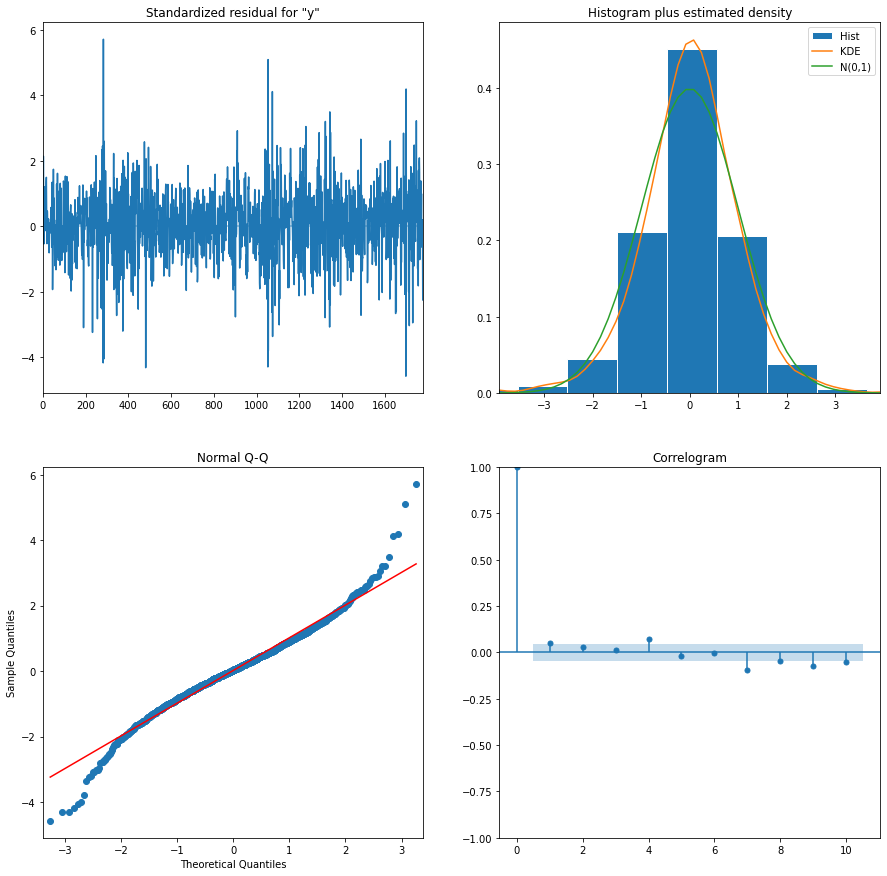

In [15]:
model = ARIMA(d, order=(2, 0, 3), trend="n")
res = model.fit()
display(res.summary())
res.plot_diagnostics(figsize=(15,15))
plt.show()

## Discussion of values

$\theta$ for MA(1) has very high P value which tells us it could be equal to zero. I will try to find second best model according to AIC and BIC.

Following models have low AIC and BIC:
(2, 0, 3) 4216.020 (original)
(0, 0, 5) 4237.192
(1, 0, 4) 4248.884
(2, 0, 1) 4252.027

I will choose the last one, because my intention is to decreate the *q* parameter, not increase it.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1782
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -2122.013
Date:                Thu, 20 Oct 2022   AIC                           4252.027
Time:                        16:32:31   BIC                           4273.969
Sample:                             0   HQIC                          4260.131
                               - 1782                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3580      0.034     10.662      0.000       0.292       0.424
ar.L2         -0.1629      0.029     -5.534      0.000      -0.221      -0.105
ma.L1          0.5235      0.028     18.944      0.000       0.469       0.578
sigma2         0.6333      0.017     37.544      0.000       0.600       0.666
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               394.82
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                            -0.02
Prob(H) (two-sided):                  0.07   Kurtosis:                         5.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

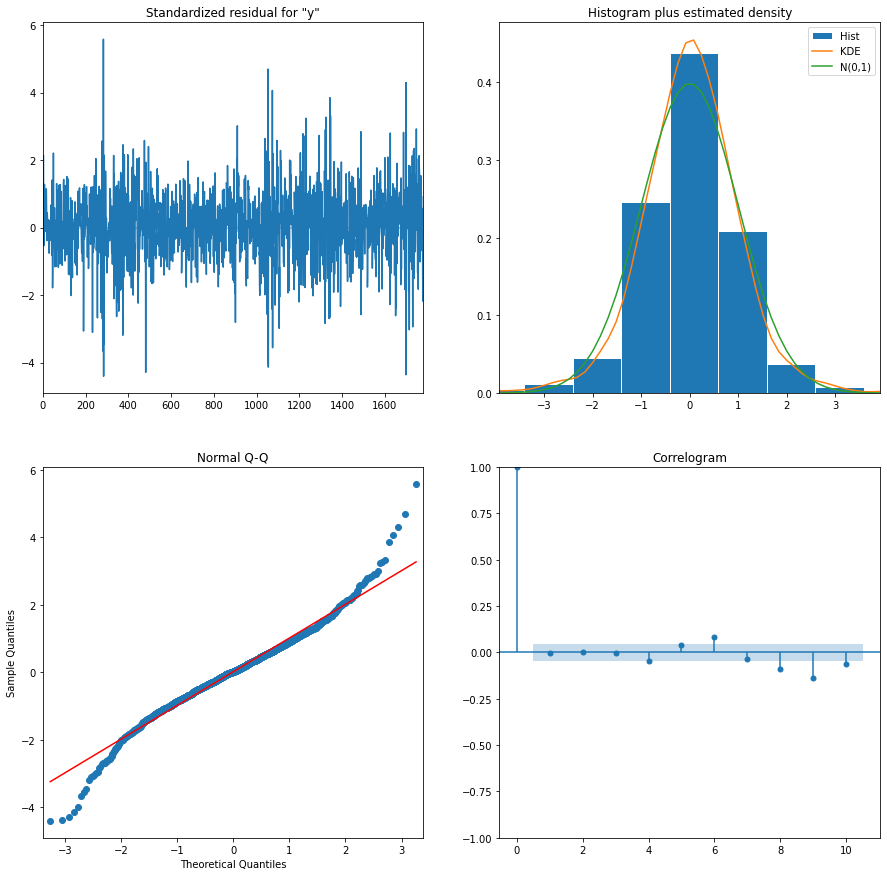

In [16]:
model = ARIMA(d, order=(2, 0, 1), trend="n")
res = model.fit()
display(res.summary())
res.plot_diagnostics(figsize=(15,15))
plt.show()

P values for fitted parameters are very low, so it is unlikely they will be zero. Good!

LogL -2122 is comparable to previous (2,0,3) model -2100. Good!

Plot of standardized residuals looks similar to white noise even though I think there are some outliers. Could be better!

Their histogram is close to histogram of Normal distr. Skew is almost normal but the kurtosis (5 vs 3) is not normal. This is confirmed by JB test which rejected $H_0$ of the distribution being normal in favor of $H_A$ that the distribution is not normal. Not good!

LjungBox does not reject $H_0$ that the residuals are independently distributed. Good!

The residues seem to have inconsistend variance and thus are heteroskedastic. Not good! Explanation - the data cover various exercises, which can have different intensity, so they will influence heart rate differently. This is expected. We cannot predict or model exercises, which we don't know.

Q-Q plot shows us we have some outliers - heavy ends. Not good!

ACF of residues shows us that the data is heteroskedastic, that bigger lags have some correlation to current datapoint.